In [263]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import os


In [264]:
from torch.utils.data import Dataset
import pandas as pd
from torchvision.transforms import transforms


class ImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(image_path).convert('L')
        image = image.resize((74, 75))
        image = np.array(image) / 255.0  # Преобразуем изображение в массив
        image = 1 - image  # Инвертируем цвета (черный и белый)
        image = torch.FloatTensor(image)
        label = self.img_labels.iloc[idx, 1]
        return image, label

train_dataset = ImageDataset(annotations_file='annotations.csv', img_dir='train-dataset')
test_dataset = ImageDataset(annotations_file='annotations-test.csv', img_dir='test-dataset')

In [265]:
batch_size = 20 #размер пачки
n_iters = 10000 # количество итераций
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)

# Обновляем создание загрузчиков данных
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=True
)

238


torch.Size([20, 75, 74])


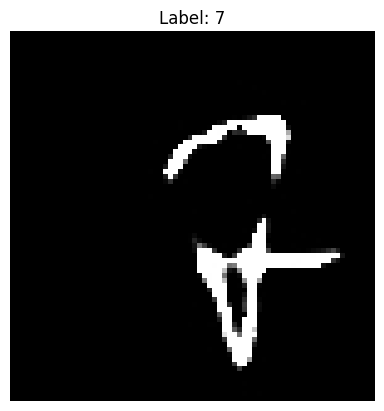

In [266]:
import matplotlib.pyplot as plt

for images, labels in train_loader:
    print(images.shape)
    plt.imshow(images[0].numpy(), cmap='gray')
    plt.title(f'Label: {labels[0]}')
    plt.axis('off')
    plt.show()
    break


In [267]:
from torch import nn
from torch.nn import ReLU, Sigmoid, Tanh

class FeedforwardNeuralNetModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedforwardNeuralNetModel, self).__init__()
        # Первый скрытый слой
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.activation1 = ReLU()
        # Второй скрытый слой
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.activation2 = ReLU()
        # Выходной слой
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out = self.fc1(x)
        out = self.activation1(out)
        out = self.fc2(out)
        out = self.activation2(out)
        out = self.fc3(out)
        return out

In [268]:
from torch.optim import Adam

input_dim = 74*75
hidden_dim = 50
output_dim = 10

model = FeedforwardNeuralNetModel(input_dim, hidden_dim, output_dim)

learning_rate = 0.0001
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=0.01)

#Loss function -- функция потерь
criterion = nn.CrossEntropyLoss()

30.0
2/238
2.0894715785980225
32.5
2/238
2.0894715785980225
38.33333206176758
2/238
2.0894715785980225
40.0
2/238
2.0894715785980225
37.0
2/238
2.0894715785980225
38.33333206176758
2/238
2.0894715785980225
40.0
2/238
2.0894715785980225
38.75
2/238
2.0894715785980225
37.77777862548828
2/238
2.0894715785980225
36.0
2/238
2.0894715785980225
20.0
4/238
1.7965978384017944
25.0
4/238
1.7965978384017944
33.33333206176758
4/238
1.7965978384017944
33.75
4/238
1.7965978384017944
36.0
4/238
1.7965978384017944
36.66666793823242
4/238
1.7965978384017944
36.42856979370117
4/238
1.7965978384017944
36.25
4/238
1.7965978384017944
38.33333206176758
4/238
1.7965978384017944
38.5
4/238
1.7965978384017944
35.0
7/238
1.605424165725708
45.0
7/238
1.605424165725708
41.66666793823242
7/238
1.605424165725708
38.75
7/238
1.605424165725708
39.0
7/238
1.605424165725708
38.33333206176758
7/238
1.605424165725708
40.0
7/238
1.605424165725708
41.25
7/238
1.605424165725708
43.33333206176758
7/238
1.605424165725708
42.0

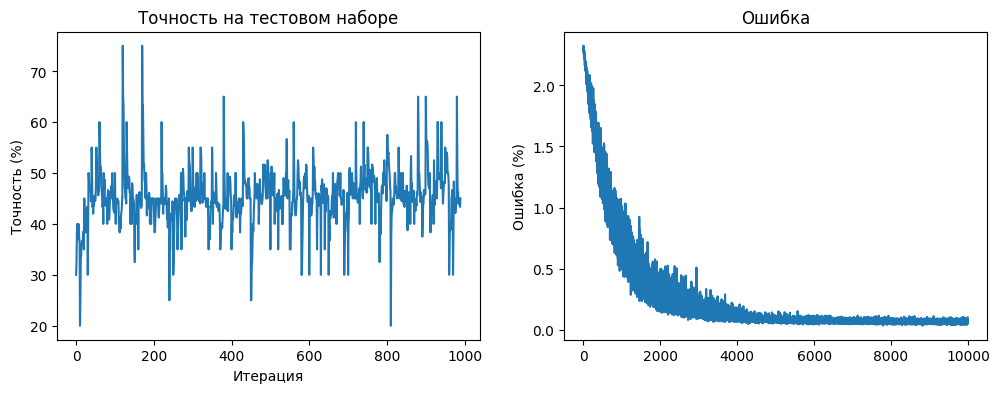

In [269]:
train_losses = []
accuracies = []

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        batch_size = images.size(0)
        images = images.view(batch_size, input_dim)  # Преобразуем в плоский вектор

        optimizer.zero_grad()

        outputs = model(images)

        # Вычисляем ошибку (Loss): softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Вычисляем градиенты для всех параметров (веса и смещения)
        loss.backward()

        # обновляем значения для всех параметров нс (веса и смещения)
        optimizer.step()
        iter += 1
        
        train_losses.append(loss.item())

        if iter % 100 == 0:
            correct = 0
            total = 0
            # Итерация на тестовом наборе данных
            for images, labels in test_loader:
                images = images.view(-1, input_dim).requires_grad_()

                # вычисления выходного значения НС
                outputs = model(images)

                # находим прогнозированной номер картинки
                _, predicted = torch.max(outputs.data, 1)

                # общее количество образов
                total += labels.size(0)

                # количество корректно классифицированных образов
                correct += (predicted == labels).sum()
                
                accuracy = 100 * correct / total
                accuracies.append(accuracy)
                print(f"{accuracy}")
                print(f"{epoch}/{num_epochs}")
                print(loss.item())
                if accuracy > 99:
                    break
            
plt.figure(figsize=(12, 4))

# График точности
plt.subplot(1, 2, 1)
plt.title('Точность на тестовом наборе')
plt.xlabel('Итерация')
plt.ylabel('Точность (%)')
plt.plot(accuracies)

# График ошибок
plt.subplot(1, 2, 2)
plt.title('Ошибка')
plt.ylabel('Ошибка (%)')
plt.plot(train_losses)

plt.show()